In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
from sklearn.metrics import confusion_matrix
#from google.colab import drive, files
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def prepare_dataset(train_valid_test_option, resize_shape=None, batch_size=32, shuffle_data=False):
  #Aggregate the data
  ROOTPATH = "."
  grass_annotations = pd.DataFrame(data = {"image": os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "grass"))
                                          ,"label":len(os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "grass")))*[0]})
  ocean_annotations = pd.DataFrame(data = {"image": os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "ocean"))
                                          ,"label":len(os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "ocean")))*[1]})
  redcarpet_annotations = pd.DataFrame(data = {"image": os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "redcarpet"))
                                          ,"label":len(os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "redcarpet")))*[2]})
  road_annotations = pd.DataFrame(data = {"image": os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "road"))
                                          ,"label":len(os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "road")))*[3]})
  wheatfield_annotations = pd.DataFrame(data = {"image": os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "wheatfield"))
                                          ,"label":len(os.listdir(os.path.join(ROOTPATH, train_valid_test_option, "wheatfield")))*[4]})

  grass_dataset = CustomDataset(
            img_dir = os.path.join(ROOTPATH, train_valid_test_option, "grass")
          , annotations = grass_annotations
          , transform = Resize(resize_shape) if resize_shape else None
  )
  ocean_dataset = CustomDataset(
            img_dir = os.path.join(ROOTPATH, train_valid_test_option, "ocean")
          , annotations = ocean_annotations
          , transform = Resize(resize_shape) if resize_shape else None
  )
  redcarpet_dataset = CustomDataset(
            img_dir = os.path.join(ROOTPATH, train_valid_test_option, "redcarpet")
          , annotations = redcarpet_annotations
          , transform = Resize(resize_shape) if resize_shape else None
  )
  road_dataset = CustomDataset(
            img_dir = os.path.join(ROOTPATH, train_valid_test_option, "road")
          , annotations = road_annotations
          , transform = Resize(resize_shape) if resize_shape else None
  )
  wheatfield_dataset = CustomDataset(
            img_dir = os.path.join(ROOTPATH, train_valid_test_option, "wheatfield")
          , annotations = wheatfield_annotations
          , transform = Resize(resize_shape) if resize_shape else None
  )
  aggregate_dataset = ConcatDataset([grass_dataset, ocean_dataset, redcarpet_dataset\
                                    ,road_dataset, wheatfield_dataset])
  final_dataloader = DataLoader(aggregate_dataset, batch_size=batch_size, shuffle=shuffle_data)
  return final_dataloader


In [3]:
#Retreiving datasets for NN training and validation set testing
training_dataloader = prepare_dataset("train", resize_shape=None, batch_size=32, shuffle_data=True)
print("Training Dataloader initialized:", len(training_dataloader.dataset))
validation_dataloader = prepare_dataset("valid", resize_shape=None, batch_size=32, shuffle_data=True)
print("Validation Dataloader initialized: ", len(validation_dataloader.dataset))
testing_dataloader = prepare_dataset("test", resize_shape=None, batch_size=32, shuffle_data=True)
print("Testing Dataloader initialized: ", len(testing_dataloader.dataset))

Training Dataloader initialized: 3500
Validation Dataloader initialized:  750
Testing Dataloader initialized:  750


In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).float(), y.to(device).to(torch.int64)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        #print(train_loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            #return train_loss/batches
    return train_loss/batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    pred_out = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device).to(torch.int64)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()#Accumulating the loss per batch
            predicted_class = pred.argmax(1)
            correct += (predicted_class == y).type(torch.float).sum().item()
            compare = torch.cat((torch.reshape(predicted_class, (len(predicted_class), 1))
                                                          , torch.reshape(y, (len(y), 1))), 1)
            pred_out.append(compare)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, torch.cat(pred_out, 0)


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_Conv(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Conv, self).__init__()
        #Images are R=240 by C=360
        self.conv_stack = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU()
        )
        
        #  Resulting image should be 60*90
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            #Padding preserves shape, but 2 max pools divides dims by 4
            nn.Linear(60*90*32, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits

Using cuda device


Epoch 1
-------------------------------
Training:
loss: 4.981244  [   32/ 3500]
loss: 1.595293  [  352/ 3500]
loss: 1.473764  [  672/ 3500]
loss: 1.378121  [  992/ 3500]
loss: 1.213845  [ 1312/ 3500]
loss: 1.357765  [ 1632/ 3500]
loss: 1.620574  [ 1952/ 3500]
loss: 1.469261  [ 2272/ 3500]
loss: 1.225049  [ 2592/ 3500]
loss: 1.254465  [ 2912/ 3500]
loss: 1.135642  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 58.3%, Avg loss: 1.127390 

Epoch 2
-------------------------------
Training:
loss: 1.052873  [   32/ 3500]
loss: 1.157790  [  352/ 3500]
loss: 1.351038  [  672/ 3500]
loss: 0.873365  [  992/ 3500]
loss: 1.212297  [ 1312/ 3500]
loss: 0.909985  [ 1632/ 3500]
loss: 1.170891  [ 1952/ 3500]
loss: 1.325726  [ 2272/ 3500]
loss: 0.934268  [ 2592/ 3500]
loss: 1.303783  [ 2912/ 3500]
loss: 0.947412  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 49.5%, Avg loss: 1.270181 

Epoch 3
-------------------------------
Training:
loss: 1.178568  [   32/ 3500]
loss: 1.110567  [  352/ 3500]
lo

loss: 0.423540  [ 1632/ 3500]
loss: 0.484495  [ 1952/ 3500]
loss: 0.723564  [ 2272/ 3500]
loss: 0.516666  [ 2592/ 3500]
loss: 0.451332  [ 2912/ 3500]
loss: 0.472358  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.637132 

Epoch 20
-------------------------------
Training:
loss: 0.582623  [   32/ 3500]
loss: 0.456807  [  352/ 3500]
loss: 0.487610  [  672/ 3500]
loss: 0.260963  [  992/ 3500]
loss: 0.378184  [ 1312/ 3500]
loss: 0.471292  [ 1632/ 3500]
loss: 0.404882  [ 1952/ 3500]
loss: 0.314655  [ 2272/ 3500]
loss: 0.349847  [ 2592/ 3500]
loss: 0.301680  [ 2912/ 3500]
loss: 0.390162  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.644902 

Epoch 21
-------------------------------
Training:
loss: 0.416495  [   32/ 3500]
loss: 0.330803  [  352/ 3500]
loss: 0.554316  [  672/ 3500]
loss: 0.513683  [  992/ 3500]
loss: 0.640789  [ 1312/ 3500]
loss: 0.334063  [ 1632/ 3500]
loss: 0.359026  [ 1952/ 3500]
loss: 0.372523  [ 2272/ 3500]
loss: 0.486634  [ 25

Test Error: 
 Accuracy: 80.4%, Avg loss: 0.599509 

Epoch 38
-------------------------------
Training:
loss: 0.423517  [   32/ 3500]
loss: 0.242327  [  352/ 3500]
loss: 0.415949  [  672/ 3500]
loss: 0.259434  [  992/ 3500]
loss: 0.398284  [ 1312/ 3500]
loss: 0.337752  [ 1632/ 3500]
loss: 0.377939  [ 1952/ 3500]
loss: 0.258034  [ 2272/ 3500]
loss: 0.343807  [ 2592/ 3500]
loss: 0.338138  [ 2912/ 3500]
loss: 0.342958  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.709603 

Epoch 39
-------------------------------
Training:
loss: 0.345589  [   32/ 3500]
loss: 0.388362  [  352/ 3500]
loss: 0.449071  [  672/ 3500]
loss: 0.418597  [  992/ 3500]
loss: 0.308382  [ 1312/ 3500]
loss: 0.433924  [ 1632/ 3500]
loss: 0.244326  [ 1952/ 3500]
loss: 0.334320  [ 2272/ 3500]
loss: 0.353452  [ 2592/ 3500]
loss: 0.277622  [ 2912/ 3500]
loss: 0.303564  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.607376 

Epoch 40
-------------------------------
Training:
loss: 0

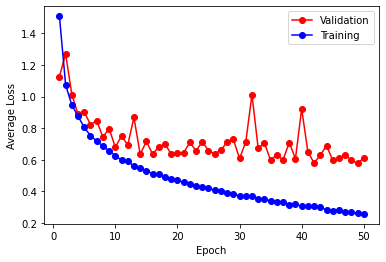

In [10]:
#Epochs = 50, Learning Rate = 1e-5
model_50_1e_5 = NeuralNetwork_Conv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_50_1e_5.parameters(), lr=1e-5)

epochs = 50
validation_losses = []
training_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_5, loss_fn, optimizer))
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_5, loss_fn)[0])
print("Done!")
plt.plot(np.linspace(1, epochs, epochs), validation_losses, marker='o', color='r', label="Validation")
plt.plot(np.linspace(1, epochs, epochs), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()


In [11]:
#Save this model to CNN_50_1e_5.pth
torch.save(model_50_1e_5.state_dict(), "./CNN_50_1e_5.pth")
#files.download("/content/gdrive/MyDrive/Colab Notebooks/CompVis/CNN_50_1e_5.pth")

Epoch 1
-------------------------------
Training:
loss: 2.362893  [   32/ 3500]
loss: 1.719367  [  352/ 3500]
loss: 1.728174  [  672/ 3500]
loss: 1.694170  [  992/ 3500]
loss: 1.536605  [ 1312/ 3500]
loss: 1.575056  [ 1632/ 3500]
loss: 1.492616  [ 1952/ 3500]
loss: 1.499861  [ 2272/ 3500]
loss: 1.467837  [ 2592/ 3500]
loss: 1.518072  [ 2912/ 3500]
loss: 1.528755  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 36.5%, Avg loss: 1.480090 

Epoch 2
-------------------------------
Training:
loss: 1.411827  [   32/ 3500]
loss: 1.732156  [  352/ 3500]
loss: 1.487048  [  672/ 3500]
loss: 1.429009  [  992/ 3500]
loss: 1.580583  [ 1312/ 3500]
loss: 1.366726  [ 1632/ 3500]
loss: 1.514494  [ 1952/ 3500]
loss: 1.602366  [ 2272/ 3500]
loss: 1.341928  [ 2592/ 3500]
loss: 1.431775  [ 2912/ 3500]
loss: 1.504369  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.372910 

Epoch 3
-------------------------------
Training:
loss: 1.271585  [   32/ 3500]
loss: 1.424435  [  352/ 3500]
lo

loss: 1.052608  [ 1632/ 3500]
loss: 1.025718  [ 1952/ 3500]
loss: 1.149382  [ 2272/ 3500]
loss: 0.664246  [ 2592/ 3500]
loss: 0.914090  [ 2912/ 3500]
loss: 1.283971  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.995457 

Epoch 20
-------------------------------
Training:
loss: 0.884706  [   32/ 3500]
loss: 0.805306  [  352/ 3500]
loss: 0.724484  [  672/ 3500]
loss: 0.945628  [  992/ 3500]
loss: 0.949989  [ 1312/ 3500]
loss: 0.940958  [ 1632/ 3500]
loss: 1.082742  [ 1952/ 3500]
loss: 0.941980  [ 2272/ 3500]
loss: 1.106454  [ 2592/ 3500]
loss: 0.930109  [ 2912/ 3500]
loss: 0.911195  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 64.9%, Avg loss: 0.977270 

Epoch 21
-------------------------------
Training:
loss: 0.821337  [   32/ 3500]
loss: 1.143401  [  352/ 3500]
loss: 0.796302  [  672/ 3500]
loss: 0.815780  [  992/ 3500]
loss: 0.969212  [ 1312/ 3500]
loss: 1.035880  [ 1632/ 3500]
loss: 0.908402  [ 1952/ 3500]
loss: 0.865121  [ 2272/ 3500]
loss: 0.887529  [ 25

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.873463 

Epoch 38
-------------------------------
Training:
loss: 0.833951  [   32/ 3500]
loss: 0.903354  [  352/ 3500]
loss: 0.843526  [  672/ 3500]
loss: 0.971928  [  992/ 3500]
loss: 0.823683  [ 1312/ 3500]
loss: 0.734035  [ 1632/ 3500]
loss: 0.736734  [ 1952/ 3500]
loss: 0.764773  [ 2272/ 3500]
loss: 0.830472  [ 2592/ 3500]
loss: 0.726243  [ 2912/ 3500]
loss: 0.975470  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.859289 

Epoch 39
-------------------------------
Training:
loss: 0.860985  [   32/ 3500]
loss: 0.919175  [  352/ 3500]
loss: 0.914802  [  672/ 3500]
loss: 0.561278  [  992/ 3500]
loss: 0.868582  [ 1312/ 3500]
loss: 0.972123  [ 1632/ 3500]
loss: 1.114378  [ 1952/ 3500]
loss: 0.626942  [ 2272/ 3500]
loss: 0.782820  [ 2592/ 3500]
loss: 0.953278  [ 2912/ 3500]
loss: 0.878485  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.863185 

Epoch 40
-------------------------------
Training:
loss: 0

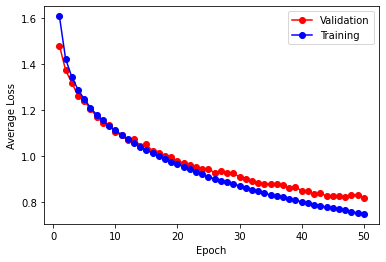

In [13]:
#Epochs = 50, Learning Rate = 1e-6
model_50_1e_6 = NeuralNetwork_Conv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_50_1e_6.parameters(), lr=1e-6)

epochs = 50
validation_losses = []
training_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_6, loss_fn, optimizer))
    #print(training_losses)
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_6, loss_fn)[0])
print("Done!")
plt.plot(np.linspace(1, epochs, epochs), validation_losses, marker='o', color='r', label="Validation")
plt.plot(np.linspace(1, epochs, epochs), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()


Epoch 51
-------------------------------
Training:
loss: 0.744815  [   32/ 3500]
loss: 0.784333  [  352/ 3500]
loss: 0.796148  [  672/ 3500]
loss: 0.538265  [  992/ 3500]
loss: 0.853080  [ 1312/ 3500]
loss: 0.546073  [ 1632/ 3500]
loss: 0.742188  [ 1952/ 3500]
loss: 0.652877  [ 2272/ 3500]
loss: 0.773498  [ 2592/ 3500]
loss: 0.620184  [ 2912/ 3500]
loss: 0.672294  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.813176 

Epoch 52
-------------------------------
Training:
loss: 0.895268  [   32/ 3500]
loss: 0.810387  [  352/ 3500]
loss: 0.877722  [  672/ 3500]
loss: 0.752938  [  992/ 3500]
loss: 0.812312  [ 1312/ 3500]
loss: 0.578486  [ 1632/ 3500]
loss: 0.528242  [ 1952/ 3500]
loss: 0.668373  [ 2272/ 3500]
loss: 0.769957  [ 2592/ 3500]
loss: 0.880882  [ 2912/ 3500]
loss: 0.900884  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.795591 

Epoch 53
-------------------------------
Training:
loss: 0.531313  [   32/ 3500]
loss: 0.574680  [  352/ 3500]

loss: 0.770647  [ 1632/ 3500]
loss: 0.675134  [ 1952/ 3500]
loss: 0.749802  [ 2272/ 3500]
loss: 0.683143  [ 2592/ 3500]
loss: 0.757799  [ 2912/ 3500]
loss: 0.585979  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.747357 

Epoch 70
-------------------------------
Training:
loss: 0.750783  [   32/ 3500]
loss: 0.550370  [  352/ 3500]
loss: 0.575149  [  672/ 3500]
loss: 0.652915  [  992/ 3500]
loss: 0.603174  [ 1312/ 3500]
loss: 0.827622  [ 1632/ 3500]
loss: 0.645607  [ 1952/ 3500]
loss: 0.507632  [ 2272/ 3500]
loss: 0.602803  [ 2592/ 3500]
loss: 0.745216  [ 2912/ 3500]
loss: 0.508864  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.750417 

Epoch 71
-------------------------------
Training:
loss: 0.706477  [   32/ 3500]
loss: 0.627913  [  352/ 3500]
loss: 0.635617  [  672/ 3500]
loss: 0.749221  [  992/ 3500]
loss: 0.512640  [ 1312/ 3500]
loss: 0.635308  [ 1632/ 3500]
loss: 0.507131  [ 1952/ 3500]
loss: 0.697194  [ 2272/ 3500]
loss: 0.823831  [ 25

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.718621 

Epoch 88
-------------------------------
Training:
loss: 0.634694  [   32/ 3500]
loss: 0.640651  [  352/ 3500]
loss: 0.576558  [  672/ 3500]
loss: 0.522746  [  992/ 3500]
loss: 0.780063  [ 1312/ 3500]
loss: 0.480247  [ 1632/ 3500]
loss: 0.976783  [ 1952/ 3500]
loss: 0.500753  [ 2272/ 3500]
loss: 0.502730  [ 2592/ 3500]
loss: 0.641646  [ 2912/ 3500]
loss: 0.552788  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.714139 

Epoch 89
-------------------------------
Training:
loss: 0.608141  [   32/ 3500]
loss: 0.640188  [  352/ 3500]
loss: 0.452838  [  672/ 3500]
loss: 0.527109  [  992/ 3500]
loss: 0.564656  [ 1312/ 3500]
loss: 0.768300  [ 1632/ 3500]
loss: 0.650786  [ 1952/ 3500]
loss: 0.730322  [ 2272/ 3500]
loss: 0.665427  [ 2592/ 3500]
loss: 0.499889  [ 2912/ 3500]
loss: 0.873287  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.731773 

Epoch 90
-------------------------------
Training:
loss: 0

ValueError: x and y must have same first dimension, but have shapes (1,) and (49,)

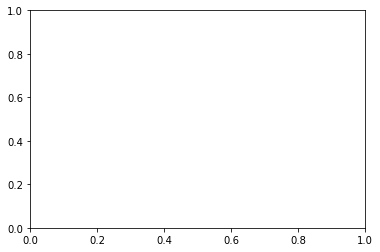

In [14]:
#Continued
#Epochs = 50, Learning Rate = 1e-6
#model_50_1e_6 = NeuralNetwork_Conv().to(device)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model_50_1e_6.parameters(), lr=1e-6)

epochs = 99
validation_losses = []
training_losses = []
for t in range(50, epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_6, loss_fn, optimizer))
    #print(training_losses)
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_6, loss_fn)[0])
print("Done!")
plt.plot(len(validation_losses), validation_losses, marker='o', color='r', label="Validation")
plt.plot(len(training_losses), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

In [16]:
#Save this model to CNN_50_1e_6.pth
torch.save(model_50_1e_6.state_dict(), "./CNN_50_1e_6.pth")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_Conv(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Conv, self).__init__()
        #Images are R=240 by C=360
        self.conv_stack = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
        )
        
        #  Resulting image should be 60*90
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            #Padding preserves shape, but 2 max pools divides dims by 4
            nn.Linear(60*90*32, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits

Using cuda device


Epoch 1
-------------------------------
Training:
loss: 2.228713  [   32/ 3500]
loss: 1.925373  [  352/ 3500]
loss: 1.753791  [  672/ 3500]
loss: 1.656554  [  992/ 3500]
loss: 1.456468  [ 1312/ 3500]
loss: 1.360551  [ 1632/ 3500]
loss: 1.447381  [ 1952/ 3500]
loss: 1.369355  [ 2272/ 3500]
loss: 1.325989  [ 2592/ 3500]
loss: 1.386948  [ 2912/ 3500]
loss: 1.215557  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 48.4%, Avg loss: 1.252166 

Epoch 2
-------------------------------
Training:
loss: 1.214299  [   32/ 3500]
loss: 1.308741  [  352/ 3500]
loss: 1.491348  [  672/ 3500]
loss: 1.362225  [  992/ 3500]
loss: 0.983700  [ 1312/ 3500]
loss: 1.281181  [ 1632/ 3500]
loss: 0.985739  [ 1952/ 3500]
loss: 0.905824  [ 2272/ 3500]
loss: 1.020942  [ 2592/ 3500]
loss: 0.710615  [ 2912/ 3500]
loss: 1.553693  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 58.3%, Avg loss: 1.062211 

Epoch 3
-------------------------------
Training:
loss: 0.712148  [   32/ 3500]
loss: 1.114568  [  352/ 3500]
lo

loss: 0.261918  [ 1632/ 3500]
loss: 0.388307  [ 1952/ 3500]
loss: 0.559541  [ 2272/ 3500]
loss: 0.440468  [ 2592/ 3500]
loss: 0.612608  [ 2912/ 3500]
loss: 0.412810  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.812628 

Epoch 20
-------------------------------
Training:
loss: 0.452174  [   32/ 3500]
loss: 0.347986  [  352/ 3500]
loss: 0.520616  [  672/ 3500]
loss: 0.407887  [  992/ 3500]
loss: 0.515862  [ 1312/ 3500]
loss: 0.531510  [ 1632/ 3500]
loss: 0.413064  [ 1952/ 3500]
loss: 0.149304  [ 2272/ 3500]
loss: 0.503431  [ 2592/ 3500]
loss: 0.410302  [ 2912/ 3500]
loss: 0.336308  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.608463 

Epoch 21
-------------------------------
Training:
loss: 0.318490  [   32/ 3500]
loss: 0.340070  [  352/ 3500]
loss: 0.809732  [  672/ 3500]
loss: 0.563313  [  992/ 3500]
loss: 0.314242  [ 1312/ 3500]
loss: 0.457157  [ 1632/ 3500]
loss: 0.405936  [ 1952/ 3500]
loss: 0.559810  [ 2272/ 3500]
loss: 0.360579  [ 25

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.586727 

Epoch 38
-------------------------------
Training:
loss: 0.262318  [   32/ 3500]
loss: 0.275534  [  352/ 3500]
loss: 0.318173  [  672/ 3500]
loss: 0.270072  [  992/ 3500]
loss: 0.263902  [ 1312/ 3500]
loss: 0.265808  [ 1632/ 3500]
loss: 0.338152  [ 1952/ 3500]
loss: 0.233313  [ 2272/ 3500]
loss: 0.188522  [ 2592/ 3500]
loss: 0.330386  [ 2912/ 3500]
loss: 0.480084  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.678172 

Epoch 39
-------------------------------
Training:
loss: 0.288081  [   32/ 3500]
loss: 0.229383  [  352/ 3500]
loss: 0.357269  [  672/ 3500]
loss: 0.343941  [  992/ 3500]
loss: 0.230263  [ 1312/ 3500]
loss: 0.246861  [ 1632/ 3500]
loss: 0.187688  [ 1952/ 3500]
loss: 0.350436  [ 2272/ 3500]
loss: 0.280568  [ 2592/ 3500]
loss: 0.287980  [ 2912/ 3500]
loss: 0.289452  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.592129 

Epoch 40
-------------------------------
Training:
loss: 0

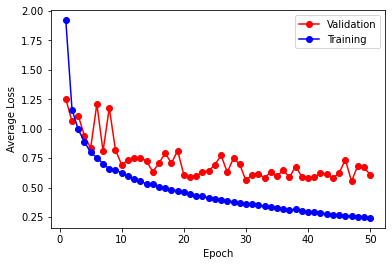

In [17]:
#Epochs = 50, Learning Rate = 1e-5, 3 input -> 32 featueres, 32 input -> 64 features, 64 -> 32 features
model_50_1e_5_1 = NeuralNetwork_Conv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_50_1e_5_1.parameters(), lr=1e-5)

epochs = 50
validation_losses = []
training_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_5_1, loss_fn, optimizer))
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_5_1, loss_fn)[0])
print("Done!")
plt.plot(np.linspace(1, epochs, epochs), validation_losses, marker='o', color='r', label="Validation")
plt.plot(np.linspace(1, epochs, epochs), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

#Save this model to CNN_50_1e_5_1.pth
torch.save(model_50_1e_5_1.state_dict(), "./CNN_50_1e_5_1.pth")


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_Conv(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Conv, self).__init__()
        #Images are R=240 by C=360
        self.conv_stack = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
        )
        
        #  Resulting image should be 60*90
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            #Padding preserves shape, but 2 max pools divides dims by 4
            nn.Linear(60*90*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits

Using cuda device


Epoch 1
-------------------------------
Training:
loss: 1.990036  [   32/ 3500]
loss: 1.520832  [  352/ 3500]
loss: 1.428596  [  672/ 3500]
loss: 1.393028  [  992/ 3500]
loss: 1.393669  [ 1312/ 3500]
loss: 1.251886  [ 1632/ 3500]
loss: 1.231560  [ 1952/ 3500]
loss: 1.338836  [ 2272/ 3500]
loss: 1.260650  [ 2592/ 3500]
loss: 1.155259  [ 2912/ 3500]
loss: 1.167247  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 63.1%, Avg loss: 1.103982 

Epoch 2
-------------------------------
Training:
loss: 1.120687  [   32/ 3500]
loss: 0.969489  [  352/ 3500]
loss: 1.235627  [  672/ 3500]
loss: 1.081688  [  992/ 3500]
loss: 1.038332  [ 1312/ 3500]
loss: 0.932425  [ 1632/ 3500]
loss: 0.896009  [ 1952/ 3500]
loss: 1.019098  [ 2272/ 3500]
loss: 1.015104  [ 2592/ 3500]
loss: 0.919173  [ 2912/ 3500]
loss: 0.862822  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.923497 

Epoch 3
-------------------------------
Training:
loss: 0.896128  [   32/ 3500]
loss: 1.179247  [  352/ 3500]
lo

loss: 0.333025  [ 1632/ 3500]
loss: 0.684506  [ 1952/ 3500]
loss: 0.831792  [ 2272/ 3500]
loss: 0.752620  [ 2592/ 3500]
loss: 0.639184  [ 2912/ 3500]
loss: 0.423371  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.624212 

Epoch 20
-------------------------------
Training:
loss: 0.466448  [   32/ 3500]
loss: 0.473728  [  352/ 3500]
loss: 0.647576  [  672/ 3500]
loss: 0.790029  [  992/ 3500]
loss: 0.656370  [ 1312/ 3500]
loss: 0.471537  [ 1632/ 3500]
loss: 0.579885  [ 1952/ 3500]
loss: 0.594476  [ 2272/ 3500]
loss: 0.551721  [ 2592/ 3500]
loss: 0.347955  [ 2912/ 3500]
loss: 0.478053  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.589668 

Epoch 21
-------------------------------
Training:
loss: 0.525101  [   32/ 3500]
loss: 0.298786  [  352/ 3500]
loss: 0.543531  [  672/ 3500]
loss: 0.630624  [  992/ 3500]
loss: 0.473268  [ 1312/ 3500]
loss: 0.526629  [ 1632/ 3500]
loss: 0.429073  [ 1952/ 3500]
loss: 0.346382  [ 2272/ 3500]
loss: 0.348920  [ 25

Test Error: 
 Accuracy: 78.3%, Avg loss: 0.591376 

Epoch 38
-------------------------------
Training:
loss: 0.429960  [   32/ 3500]
loss: 0.689739  [  352/ 3500]
loss: 0.383062  [  672/ 3500]
loss: 0.580111  [  992/ 3500]
loss: 0.226452  [ 1312/ 3500]
loss: 0.309427  [ 1632/ 3500]
loss: 0.541990  [ 1952/ 3500]
loss: 0.332090  [ 2272/ 3500]
loss: 0.293895  [ 2592/ 3500]
loss: 0.252455  [ 2912/ 3500]
loss: 0.383452  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.550111 

Epoch 39
-------------------------------
Training:
loss: 0.207349  [   32/ 3500]
loss: 0.328671  [  352/ 3500]
loss: 0.529637  [  672/ 3500]
loss: 0.719251  [  992/ 3500]
loss: 0.407883  [ 1312/ 3500]
loss: 0.277318  [ 1632/ 3500]
loss: 0.426070  [ 1952/ 3500]
loss: 0.413652  [ 2272/ 3500]
loss: 0.335228  [ 2592/ 3500]
loss: 0.396287  [ 2912/ 3500]
loss: 0.572165  [ 3232/ 3500]
Validation:
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.551646 

Epoch 40
-------------------------------
Training:
loss: 0

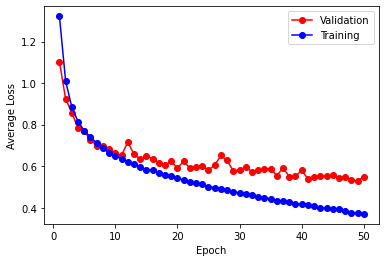

In [20]:
#Epochs = 50, Learning Rate = 1e-5, 3 input -> 32 featueres, 32 input -> 64 features, 64 -> 32 features, additional hidden layer for NN
model_50_1e_5_2 = NeuralNetwork_Conv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_50_1e_5_2.parameters(), lr=1e-5)

epochs = 50
validation_losses = []
training_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_5_2, loss_fn, optimizer))
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_5_2, loss_fn)[0])
print("Done!")
plt.plot(np.linspace(1, epochs, epochs), validation_losses, marker='o', color='r', label="Validation")
plt.plot(np.linspace(1, epochs, epochs), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

#Save this model to CNN_50_1e_5_2.pth
torch.save(model_50_1e_5_2.state_dict(), "./CNN_50_1e_5_2.pth")


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork_Conv(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Conv, self).__init__()
        #Images are R=240 by C=360
        self.conv_stack = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(2,2),
           nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
        )
        
        #  Resulting image should be 60*90
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(60*90*64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        logits = self.fc_stack(self.conv_stack(x))
        return logits

Using cuda device


In [10]:
#Epochs = 50, Learning Rate = 1e-5, 3 input -> 32 featueres, 32 input -> 64 features, 64 -> 128 features, 128 -> 64 features stride=1
#additional hidden layer for NN
model_50_1e_5_3 = NeuralNetwork_Conv().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_50_1e_5_3.parameters(), lr=1e-5)

epochs = 50
validation_losses = []
training_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    training_losses.append(train(training_dataloader, model_50_1e_5_3, loss_fn, optimizer))
    print("Validation:")
    validation_losses.append(test(validation_dataloader, model_50_1e_5_3, loss_fn)[0])
print("Done!")
plt.plot(np.linspace(1, epochs, epochs), validation_losses, marker='o', color='r', label="Validation")
plt.plot(np.linspace(1, epochs, epochs), training_losses, marker='o', color='b', label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

#Save this model to CNN_50_1e_5_3.pth
torch.save(model_50_1e_5_3.state_dict(), "./CNN_50_1e_5_3.pth")


Epoch 1
-------------------------------
Training:


RuntimeError: CUDA out of memory. Tried to allocate 676.00 MiB (GPU 0; 4.00 GiB total capacity; 2.16 GiB already allocated; 0 bytes free; 2.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
torch.cuda.empty_cache()

In [14]:
#Applying CNN_50_1e_5 to testing data
model_50_1e_5_loaded = NeuralNetwork_Conv().to(device)

model_50_1e_5_loaded.load_state_dict(torch.load("./CNN_50_1e_5.pth"
                                      ,map_location=device))
loss_fn = nn.CrossEntropyLoss()

_ , pred_vs_actual = test(testing_dataloader, model_50_1e_5_loaded, loss_fn)
print(confusion_matrix(pred_vs_actual.cpu().numpy()[:,1], pred_vs_actual.cpu().numpy()[:,0]))

Test Error: 
 Accuracy: 75.3%, Avg loss: 0.735012 

[[ 94   4   0  18  34]
 [  3  93   3  37  14]
 [  1   1 133  10   5]
 [  4   5   6 125  10]
 [ 11   5   2  12 120]]


In [6]:
#Applying CNN_50_1e_5_2 to testing data
model_50_1e_5_2_loaded = NeuralNetwork_Conv().to(device)

model_50_1e_5_2_loaded.load_state_dict(torch.load("./CNN_50_1e_5_2.pth"
                                      ,map_location=device))
loss_fn = nn.CrossEntropyLoss()

_ , pred_vs_actual = test(testing_dataloader, model_50_1e_5_2_loaded, loss_fn)
print(confusion_matrix(pred_vs_actual.cpu().numpy()[:,1], pred_vs_actual.cpu().numpy()[:,0]))

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.641141 

[[106   8   1  18  17]
 [  3 107   1  27  12]
 [  1   1 140   7   1]
 [  8   8   3 116  15]
 [ 18   8   3  16 105]]


In [6]:
#Applying CNN_50_1e_5_3 to testing data
model_50_1e_5_3_loaded = NeuralNetwork_Conv().to(device)

model_50_1e_5_3_loaded.load_state_dict(torch.load("./CNN_50_1e_5_3.pth"
                                      ,map_location=device))
loss_fn = nn.CrossEntropyLoss()

_ , pred_vs_actual = test(testing_dataloader, model_50_1e_5_3_loaded, loss_fn)
print(confusion_matrix(pred_vs_actual.cpu().numpy()[:,1], pred_vs_actual.cpu().numpy()[:,0]))

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.642606 

[[120   4   1  11  14]
 [ 13  98   2  30   7]
 [  1   0 138  10   1]
 [ 14   6   2 118  10]
 [ 30   3   4  12 101]]
